# Settings

> <p style="line-height=1.8em">Ref. "Titanic Top 4% with ensemble modeling" by YASSINE GHOUZAM from kaggle <br>
https://www.kaggle.com/code/yassineghouzam/titanic-top-4-with-ensemble-modeling <br>
This code is transcribed for practice.
</p>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

In [2]:
plt.rc("font", family="Malgun Gothic", size=14)
plt.rc("axes", labelsize=14, titlesize=14, unicode_minus=False)
plt.rc("legend", fontsize=14)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)

# Load data and Check

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
IDtest = test["PassengerId"]

In [4]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Outliers detection

In [6]:
def detect_outliers(df, n, features):
    outlier_indices = []
    
    for col in features:
        Q1 = np.percentile(df[col], 25) # 1사분위
        Q3 = np.percentile(df[col], 75) # 3사분위
        IQR = Q3 - Q1
        
        outlier_step = 1.5 * IQR
        
        # Q1 - IQR보다 작거나 Q3 + IQR보다 큰 값 이상치
        # iterable
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        
        # iterable의 모든 원소 리스트에 추가
        outlier_indices.extend(outlier_list_col)
        
    # 리스트의 값 카운팅하여 key(값) : value(횟수) 형태 딕셔너리 저장
    outlier_indices = Counter(outlier_indices)
    # k,v 호출 하여 n보다 큰 key 리스트 저장
    multiple_outliers = list( k for k,v in outlier_indices.items() if v > n )

    return multiple_outliers

# numerical value에 대한 이상치 검출
outliers_to_drop = detect_outliers(train, 2, ["Age", "SibSp", "Parch", "Fare"])

In [7]:
train.loc[outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


In [8]:
# Drop outliers
train = train.drop(outliers_to_drop, axis=0).reset_index(drop=True)

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


## Joining train and test

In [10]:
# to obtain the same number of categorical conversion (feature engineering)
train_len = len(train)
dataset = pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

## Check the null data

In [11]:
dataset = dataset.fillna(np.nan)
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

In [12]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


In [14]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


- survived의 NaN값은 test의 것

# Feature analysis

## Numerical values

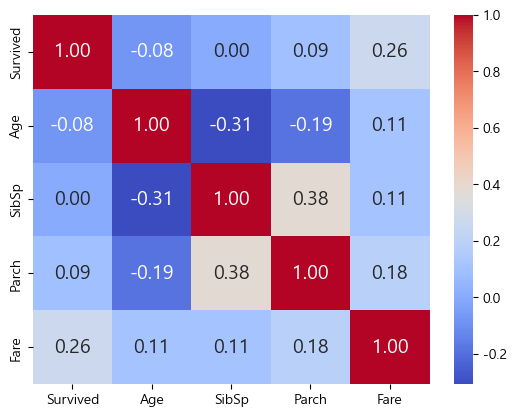

In [15]:
g = sns.heatmap(train[["Survived", "Age", "SibSp", "Parch", "Fare"]].corr(), annot=True, fmt=".2f",
                cmap="coolwarm")

### SibSp

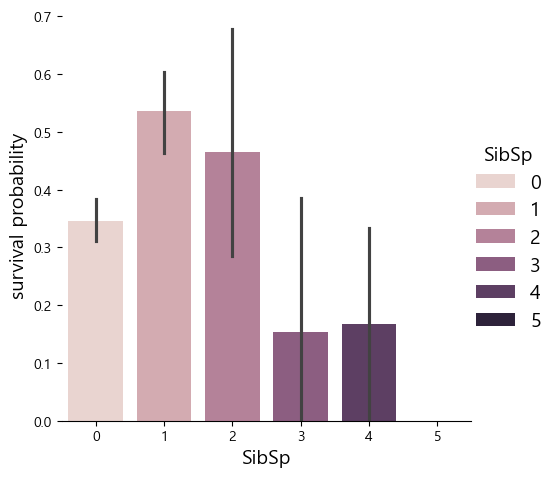

In [16]:
g = sns.catplot(data=train, x="SibSp", y="Survived", kind="bar", hue="SibSp")
g.despine(left=True)
g = g.set_ylabels("survival probability")

- SibSp가 큰 데이터는 survived 작은 거 같음

### Parch

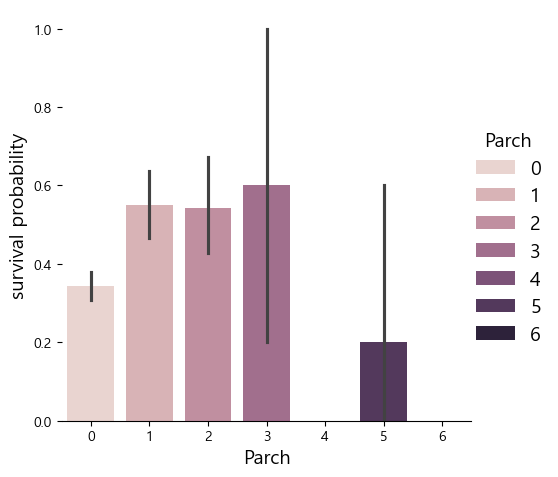

In [17]:
g = sns.catplot(data=train, x="Parch", y="Survived", kind="bar", hue="Parch")
g.despine(left=True)
g = g.set_ylabels("survival probability")

- small parch has more chance to survive
- [parch] == 3, be carefull deviation

### Age

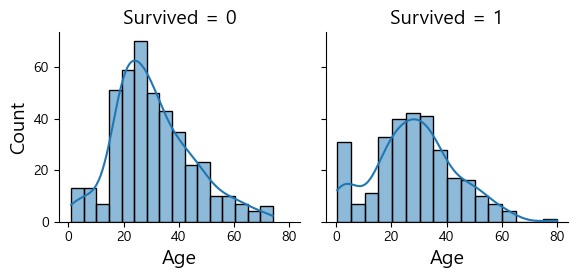

In [18]:
# Age distribution
g = sns.FacetGrid(train, col="Survived")
g = g.map(sns.histplot, "Age", kde=True)

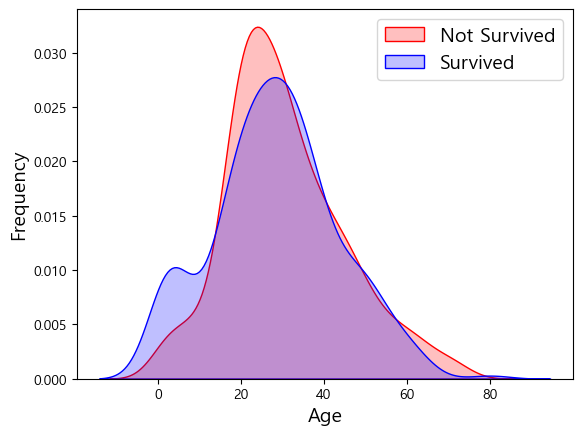

In [19]:
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())],
                color="Red", fill=True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())],
                color="Blue", fill=True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived", "Survived"])

- like gaussian distribution
- young passengers have more chance to survive

### Fare

In [20]:
dataset["Fare"].isnull().sum()

1

In [21]:
# one missing value, fill median value
dataset["Fare"] = dataset["Fare"].fillna(dataset["Fare"].median())

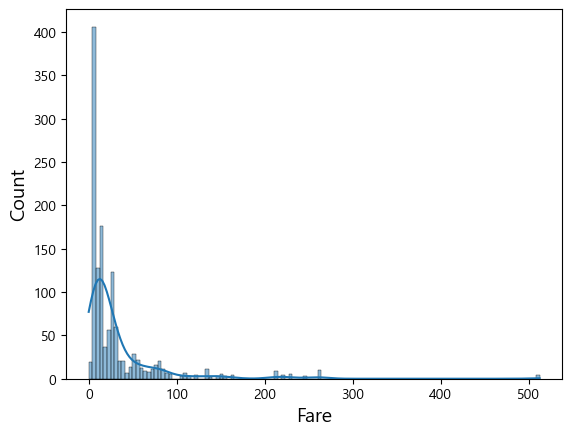

In [22]:
# Fare distribution is very skewed
g = sns.histplot(dataset["Fare"], kde=True, fill=True)

In [23]:
# log transformation to reduce skewnesss
dataset["Fare"] = dataset["Fare"].map(lambda x: np.log(x) if x > 0 else 0)

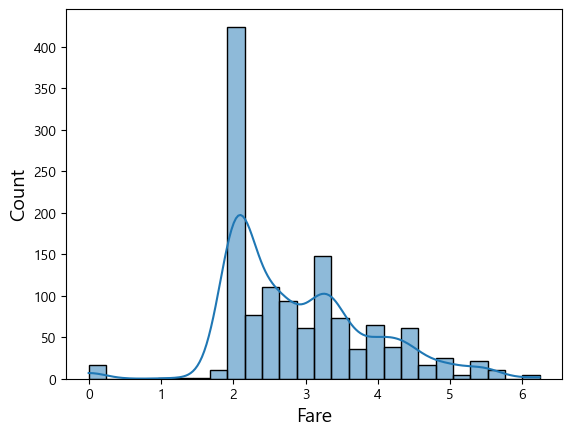

In [24]:
g = sns.histplot(dataset["Fare"], kde=True, fill=True)

## Categorical values

### Sex

Text(0, 0.5, 'Survival Probability')

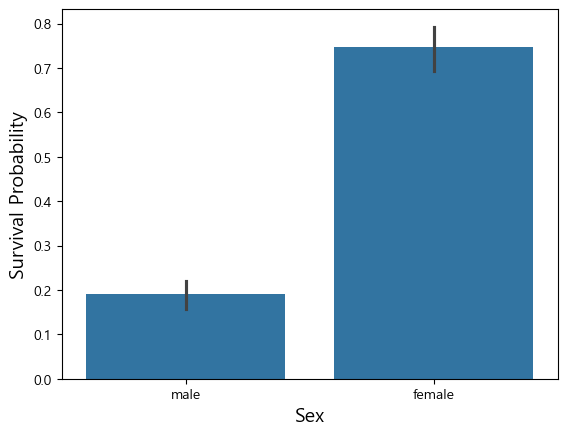

In [25]:
g = sns.barplot(train, x="Sex", y="Survived")
g.set_ylabel("Survival Probability")

In [26]:
train[["Sex", "Survived"]].groupby("Sex").mean()

,Survived
Sex,
female,0.747573
male,0.190559


- obviously, female has more chance to survive
- "Sex" is the significant feature to predict survive

### Pclass

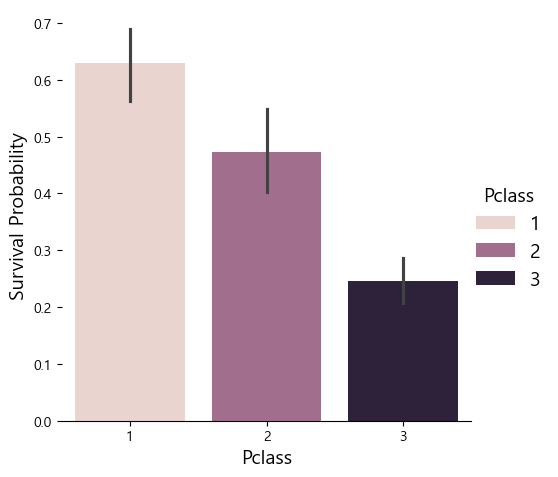

In [27]:
# Pclass with survival probability
g = sns.catplot(train, x="Pclass", y="Survived", kind="bar", hue="Pclass")
g.despine(left=True)
g = g.set_ylabels("Survival Probability")

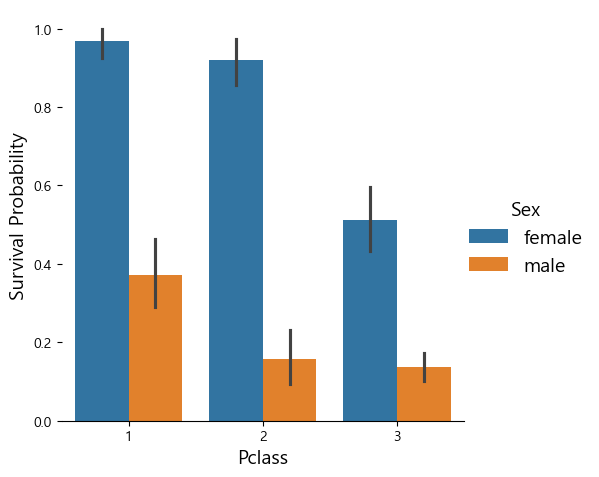

In [28]:
# Pclass with sex
g = sns.catplot(train, x="Pclass", y="Survived", kind="bar", hue="Sex")
g.despine(left=True)
g = g.set_ylabels("Survival Probability")

- First class passenger has more chane to survive than other class
- This trend is conserved both of sex

### Embarked

In [29]:
# missing value
dataset["Embarked"].isnull().sum()

2

In [30]:
# most frequenct value
dataset["Embarked"].value_counts()

Embarked
S    904
C    270
Q    123
Name: count, dtype: int64

In [31]:
# fillna with most frequenct value
dataset["Embarked"] = dataset["Embarked"].fillna("S")

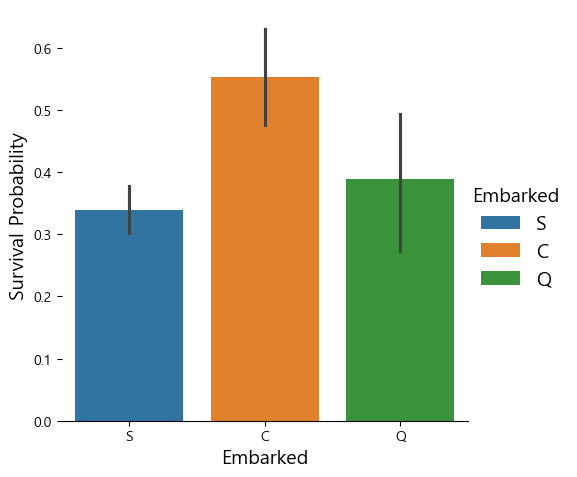

In [32]:
# Embarked with survival probability
g = sns.catplot(train, x="Embarked", y="Survived", hue="Embarked", kind="bar")
g.despine(left=True)
g = g.set_ylabels("Survival Probability")

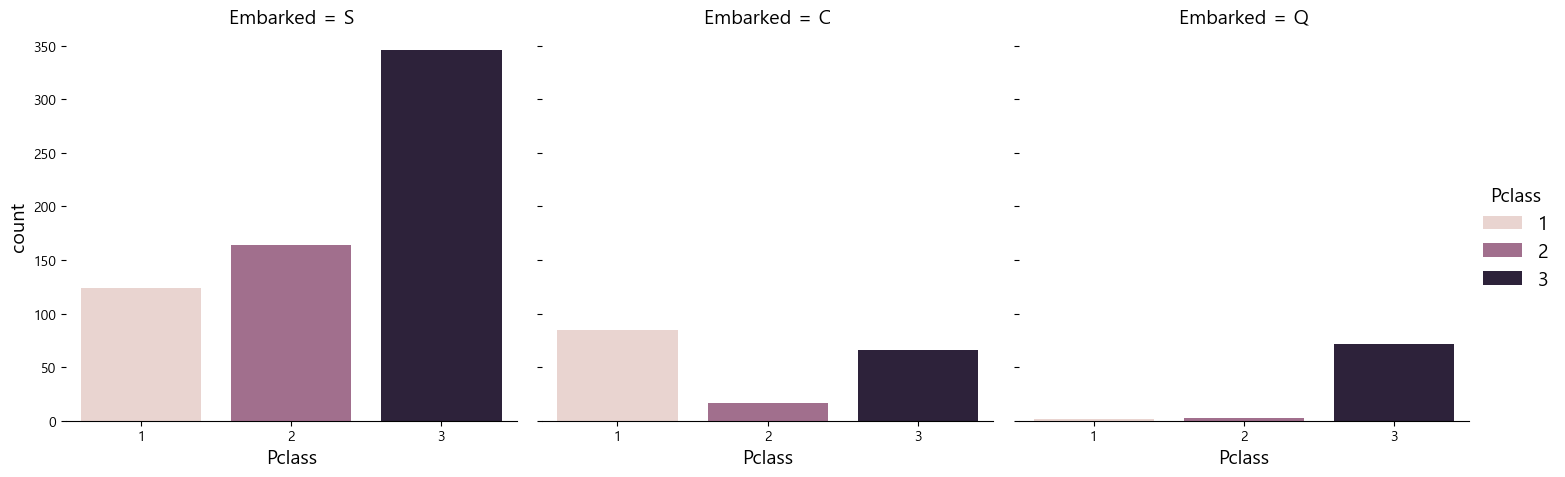

In [33]:
# H: Embarked=="C" passenger's class is first class
g = sns.catplot(data=train, x="Pclass", col="Embarked", kind="count", hue="Pclass")
# col의 값(범주형)에 따라 각 범주의 서브 플롯이 생성됨
g.despine(left=True)
g = g.set_ylabels("count")

# Filling missing value

In [34]:
# missing value except Survived
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1299 entries, 0 to 1298
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1299 non-null   int64  
 1   Survived     881 non-null    float64
 2   Pclass       1299 non-null   int64  
 3   Name         1299 non-null   object 
 4   Sex          1299 non-null   object 
 5   Age          1043 non-null   float64
 6   SibSp        1299 non-null   int64  
 7   Parch        1299 non-null   int64  
 8   Ticket       1299 non-null   object 
 9   Fare         1299 non-null   float64
 10  Cabin        292 non-null    object 
 11  Embarked     1299 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 121.9+ KB


## Age

- Age는 어린 연령 집단이 생존 확률이 더 컸음
- 이를 유지한 채로, 결측치 채워야 함

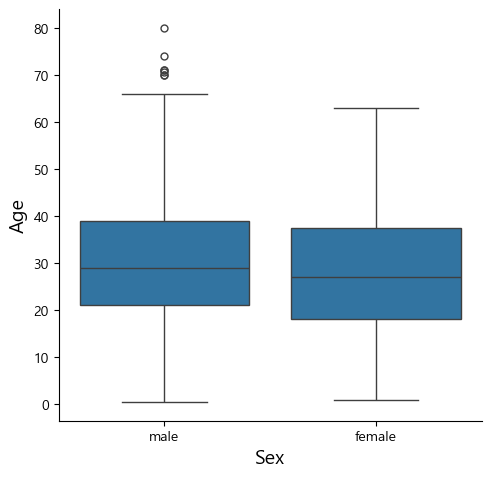

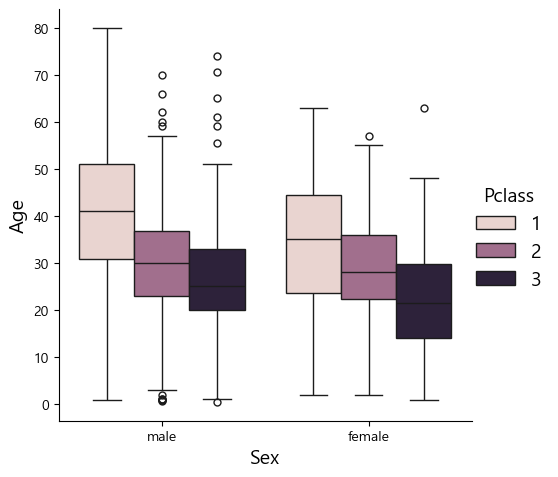

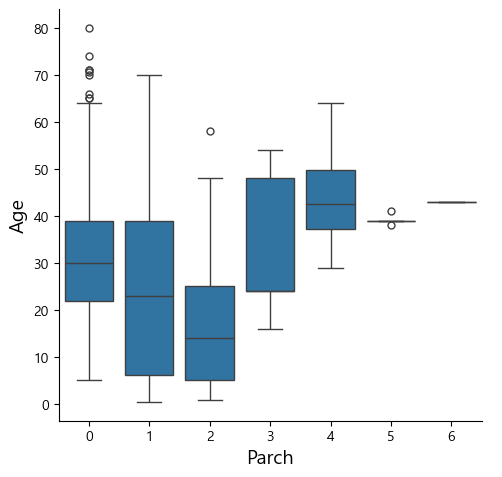

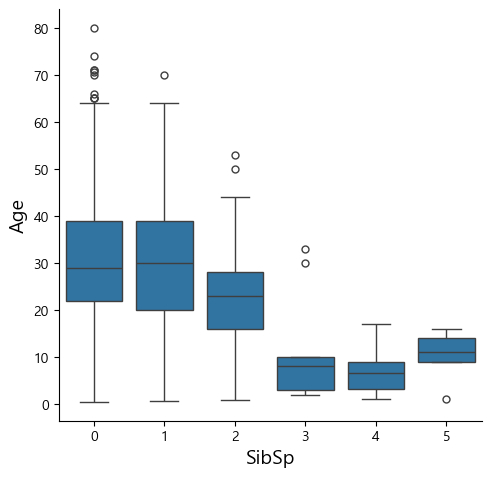

In [35]:
g = sns.catplot(data=train, x="Sex", y="Age", kind="box")
g = sns.catplot(data=train, x="Sex", y="Age", hue="Pclass", kind="box")
g = sns.catplot(data=train, x="Parch", y="Age", kind="box")
g = sns.catplot(data=train, x="SibSp", y="Age", kind="box")

1. 나이와 클래스는 반대
2. SibSp 3, 4, 5는 나이가 어림
3. Parch 3, 4, 5, 6은 나이가 많음
4. Sex는 상관 관계 없는ㄷ스

In [36]:
# convert categorical value to categorical number
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female": 1})

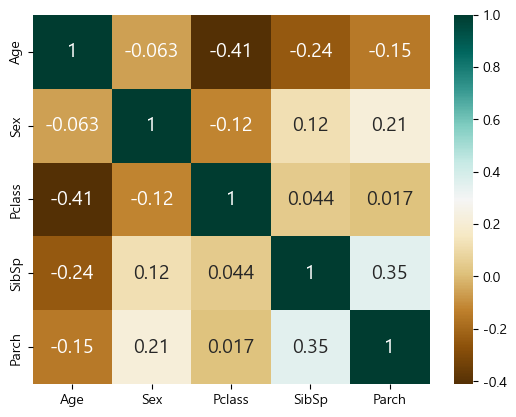

In [37]:
# correlation map to confirm above catplot
g = sns.heatmap(dataset[["Age", "Sex", "Pclass", "SibSp", "Parch"]].corr(),
                annot=True, cmap="BrBG")

- Age의 누락값을 그 행의 Pclass, SibSp, Parch의 유사한 값의 행의 평균으로 대체

In [38]:
# Filling missing value of age

index_nan_age = list(dataset[dataset["Age"].isnull()].index)

for i in index_nan_age:
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset["SibSp"]==dataset.iloc[i]["SibSp"]) &
                              (dataset["Pclass"]==dataset.iloc[i]["Pclass"]) &
                              (dataset["Parch"]==dataset.iloc[i]["Parch"]))].median()
    if not np.isnan(age_pred):
        dataset["Age"].iloc[i] = age_pred
    else:
        dataset["Age"].iloc[i] = age_med

C:\Users\admin\AppData\Local\Temp\ipykernel_23224\3812389815.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["Age"].iloc[i] = age_pred
C:\Users\admin\AppData\Local\Temp\ipykernel_23224\3812389815.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["Age"].iloc[i] = age_pred
C:\Users\admin\AppData\Local\Temp\ipykernel_23224\3812389815.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["Age"].iloc[i] = age_

C:\Users\admin\AppData\Local\Temp\ipykernel_23224\3812389815.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["Age"].iloc[i] = age_pred
C:\Users\admin\AppData\Local\Temp\ipykernel_23224\3812389815.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["Age"].iloc[i] = age_pred
C:\Users\admin\AppData\Local\Temp\ipykernel_23224\3812389815.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["Age"].iloc[i] = age_

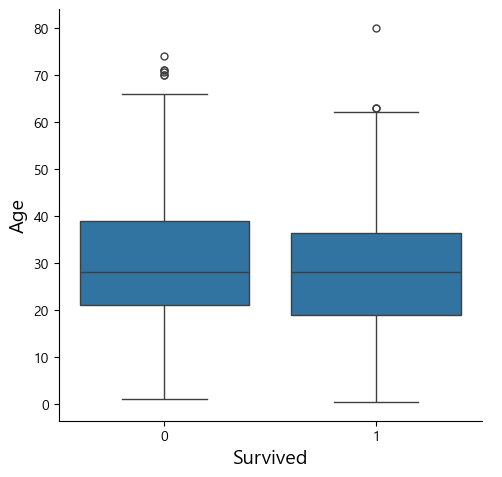

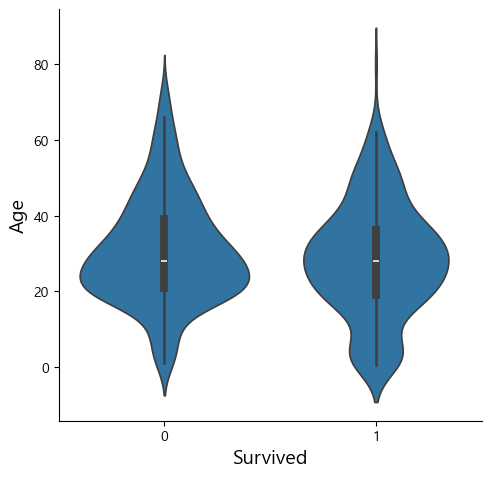

In [39]:
g = sns.catplot(data=train, x="Survived", y="Age", kind="box")
g = sns.catplot(data=train, x="Survived", y="Age", kind="violin")

# Feature engineering

## Name/Title

In [40]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

- The Name feature contains information on passenger's title.


- Since some passenger with distingused title(Mr, Mrs, ..) may be preferred during the evacuation, it is interesting to add them to the model.

In [41]:
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,1.981001,NaN,S,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,4.266662,C85,C,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,S,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,3.972177,C123,S,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,2.085672,NaN,S,Mr


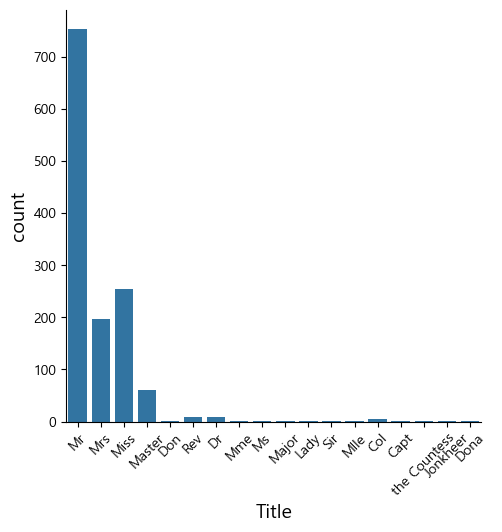

In [42]:
g = sns.catplot(data=dataset, x="Title", kind="count")
g.set_xticklabels(rotation=45)

In [43]:
dataset["Title"].value_counts()

Title
Mr              753
Miss            255
Mrs             197
Master           60
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: count, dtype: int64

> <p style="line-height: 2em">Mr:성인 남성, Miss: 미혼 여성, Mrs: 기혼 여성, Master: 어린 남성 (주로 소년), Lady: 귀부인, Sir: 기사 작위가 있는 남성, Don: 스페인, 포르투갈에서 존경받는 남성, the Countess: 백작 부인, Jonkheer: 네덜란드의 귀족 계층, Dona: 스페인, 포르투갈에서 존경받는 여성, Col: 대령, Major: 소령, Capt: 대위, Dr: 의사, Rev: 목사, Mlle: 프랑스어로 Miss에 해당하는 직함 (미혼 여성), Ms: 결혼 여부와 관계없이 사용하는 여성의 직함, Mme: 프랑스어로 Mrs에 해당하는 직함 (기혼 여성)</p>

In [44]:
# convert to categorical values
dataset["Title"] = dataset["Title"].replace(["Lady", "Sir", "Don", "the Countess", "Countess", "Jonkheer", 
                                             "Dona", "Col", "Major", "Capt", "Dr", "Rev"], "Rare")
dataset["Title"] = dataset["Title"].map({"Master": 0, "Miss": 1, "Ms": 1, "Mme": 1, "Mlle": 1, 
                                         "Mrs": 1, "Mr": 2, "Rare": 3})
dataset["Title"] = dataset["Title"].astype(int)

C:\Users\admin\AppData\Local\Temp\ipykernel_23224\735913128.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(["Master", "Miss/Ms/Mme/Mlle/Mrs", "Mr", "Rare"])


[Text(0, 0, 'Master'),
 Text(1, 0, 'Miss/Ms/Mme/Mlle/Mrs'),
 Text(2, 0, 'Mr'),
 Text(3, 0, 'Rare')]

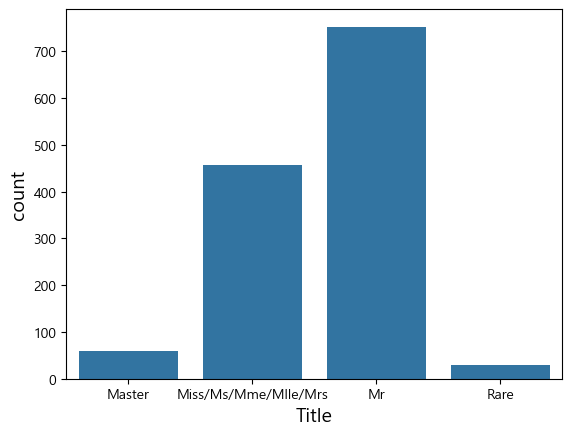

In [45]:
g = sns.countplot(data=dataset, x="Title")
g.set_xticklabels(["Master", "Miss/Ms/Mme/Mlle/Mrs", "Mr", "Rare"])

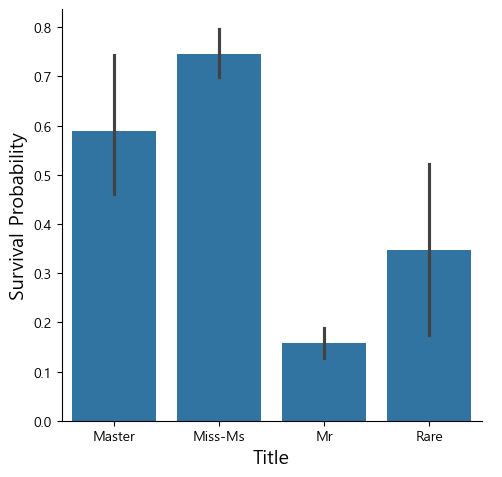

In [46]:
# Title with survive
g = sns.catplot(data=dataset, x="Title", y="Survived", kind="bar")
g = g.set_xticklabels(["Master", "Miss-Ms", "Mr", "Rare"])
g = g.set_ylabels("Survival Probability")

<p style="font-style:italic; font-size:20px"> "Women and children first" </p>

In [47]:
# drop Name columns
dataset.drop(labels=["Name"], axis=1, inplace=True)

## Familiy size

- 가족이 많은 경우, 대피하는 동안 어려움이 있는 것을 가정하여 Fsize(familiy size)
    - SibSp + Parch + 1(self)

In [48]:
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1

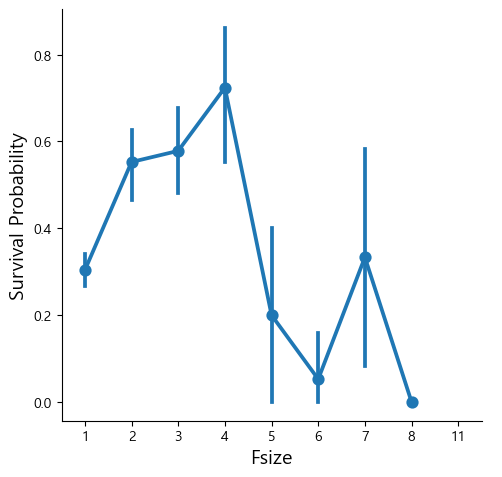

In [49]:
# survival probabiliy by size
g = sns.catplot(data=dataset, x="Fsize", y="Survived", kind="point")
g = g.set_ylabels("Survival Probability")

<p style="font-style: italic; font-size:18px; line-height:1.8em"> survival probabiliy is worst for large familiy </p>  
- create 4 categories for famlily size

In [50]:
dataset["Single"] = dataset["Fsize"].map(lambda s: 1 if s == 1 else 0)
dataset["SmallF"] = dataset["Fsize"].map(lambda s: 1 if s == 2 else 0)
dataset["MedF"] = dataset["Fsize"].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset["LargeF"] = dataset["Fsize"].map(lambda s: 1 if s >= 5 else 0)

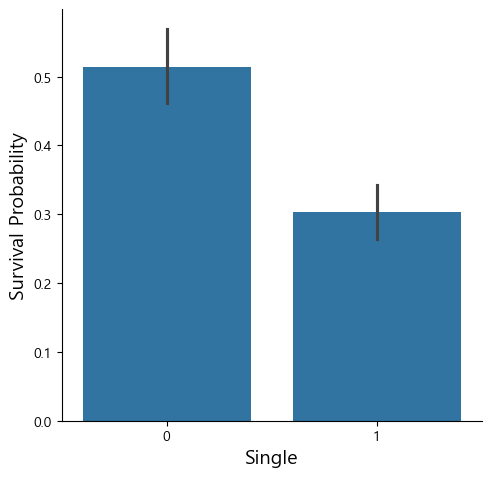

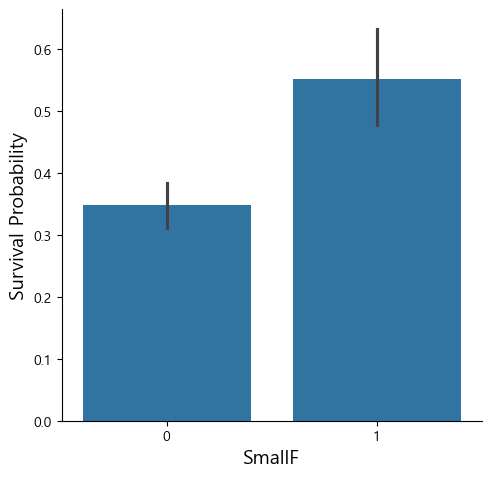

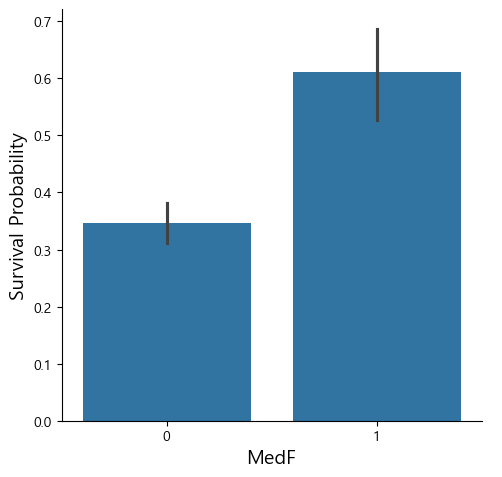

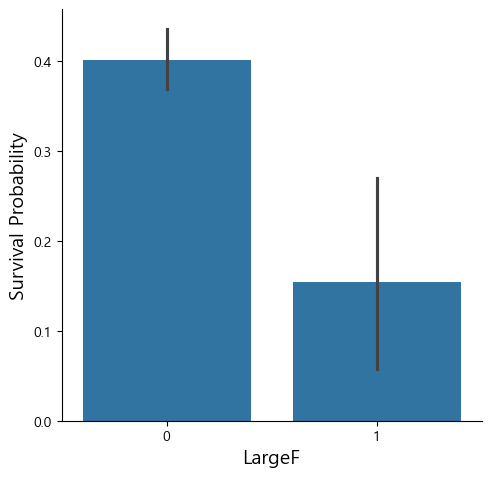

In [51]:
g = sns.catplot(data=dataset, x="Single", y="Survived", kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(data=dataset, x="SmallF", y="Survived", kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(data=dataset, x="MedF", y="Survived", kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.catplot(data=dataset, x="LargeF", y="Survived", kind="bar") 
g = g.set_ylabels("Survival Probability")

- SmallF and MedF have more chance to survive

In [52]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,Fsize,Single,SmallF,MedF,LargeF
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,S,2,2,0,1,0,0
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,C,1,2,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,S,1,1,1,0,0,0
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,S,1,2,0,1,0,0
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,S,2,1,1,0,0,0


<p style="font-size: 18px; line-height:1.8em; font-weight: bold"> Need to OneHot </p>

In [53]:
# convert to indicator values
dataset = pd.get_dummies(data=dataset, columns=["Title"], dtype=int)
dataset = pd.get_dummies(data=dataset, columns=["Embarked"], prefix="Em", dtype=int)

In [54]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


## Cabin

In [55]:
dataset["Cabin"]

0        NaN
1        C85
2        NaN
3       C123
4        NaN
        ... 
1294     NaN
1295    C105
1296     NaN
1297     NaN
1298     NaN
Name: Cabin, Length: 1299, dtype: object

In [56]:
dataset["Cabin"].isnull().sum()

1007

In [57]:
dataset["Cabin"].describe()

count     292
unique    186
top        G6
freq        5
Name: Cabin, dtype: object

In [58]:
dataset["Cabin"] = pd.Series([ i[0] if not pd.isnull(i) else "X" for i in dataset["Cabin"] ])

Cabin이 있다면 0번째 인덱스, 없다면 "X"  
번호는 신경 X

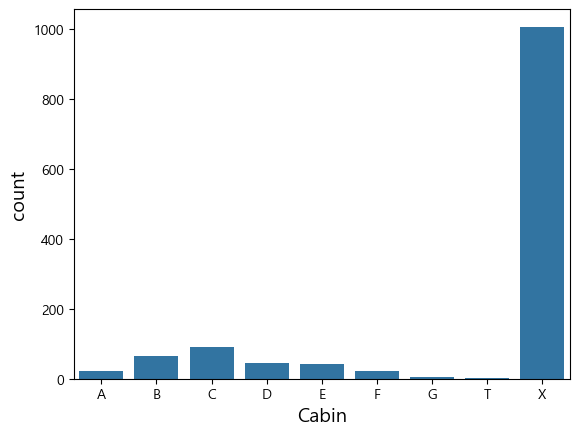

In [59]:
g = sns.countplot(data=dataset, x="Cabin", order=["A", "B", "C", "D", "E", "F", "G", "T", "X"])

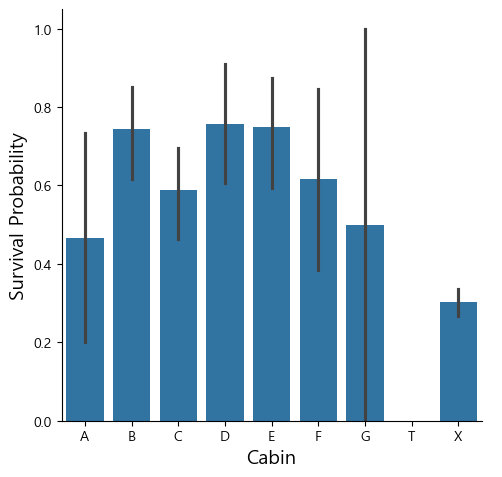

In [60]:
g = sns.catplot(data=dataset, x="Cabin", y="Survived", kind="bar",
                order=["A", "B", "C", "D", "E", "F", "G", "T", "X"])
g.set_ylabels("Survival Probability")

> <p style="line-height:1.8em"> 그러나 우리는 객실이 있는 승객이 없는 승객보다 일반적으로 생존 가능성이 더 높다는 것을 알 수 있습니다(X)  특히 B, C, D, E, F 객실의 경우가 그렇습니다.</p>

In [61]:
dataset = pd.get_dummies(dataset, columns=["Cabin"], prefix="Cabin", dtype=int)

In [62]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Fsize,...,Em_S,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_X
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,2,...,1,0,0,0,0,0,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,2,...,0,0,0,1,0,0,0,0,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,1,...,1,0,0,0,0,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,2,...,1,0,0,1,0,0,0,0,0,0
4,5,0.0,3,0,35.0,0,0,373450,2.085672,1,...,1,0,0,0,0,0,0,0,0,1


## Ticket

In [63]:
dataset["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

> 티켓의 앞부분이 유사하면 객실과 등급과 생존과 유사할 수 있음

In [64]:
# extracting with ticket prefix. when there is no ticket prefix -> X
Ticket = []

for i in list(dataset.Ticket):
    if not i.isdigit():
        Ticket.append(i.replace('/', '').replace('.','').strip().split(' ')[0])
    else:
        Ticket.append('X')
        
dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [65]:
dataset = pd.get_dummies(data=dataset, columns=["Ticket"], prefix="T", dtype=int)

In [66]:
# create categorical values for Pclass
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(data=dataset, columns=["Pclass"], prefix="Pc", dtype=int)

In [67]:
dataset.drop(labels="PassengerId", axis=1, inplace=True)

In [68]:
dataset.iloc[:5, :]

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


# Modeling

In [69]:
# seperate train and test
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=["Survived"], axis=1, inplace=True)

C:\Users\admin\AppData\Local\Temp\ipykernel_23224\416293462.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(labels=["Survived"], axis=1, inplace=True)


In [70]:
# seperate train features and label
train["Survived"] = train["Survived"].astype(int)
y_train = train["Survived"]
X_train = train.drop(labels=["Survived"], axis=1)

C:\Users\admin\AppData\Local\Temp\ipykernel_23224\2557641738.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Survived"] = train["Survived"].astype(int)


## Simple modeling

### Cross validate models

<p style="line-height:1.8em"> evaluate mean accuracy by k fold cross validation<br>
    - SVC <br>
    - Decision tree <br>
    - AdaBoost <br>
    - Random Forest <br>
    - Extra Trees <br>
    - Gradient Boosting <br>
    - Multiple layer perceprton (neural network)<br>
    - KNN<br>
    - Logistic regression<br>
    - Linear Discriminant Analysis</p>

In [71]:
# cross validate model
kfold = StratifiedKFold(n_splits=10)

C:\Users\admin\AppData\Local\Temp\ipykernel_23224\539055817.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  g = sns.barplot(data=cv_res, x="CrossValMeans", y="Algorithms", orient="h",


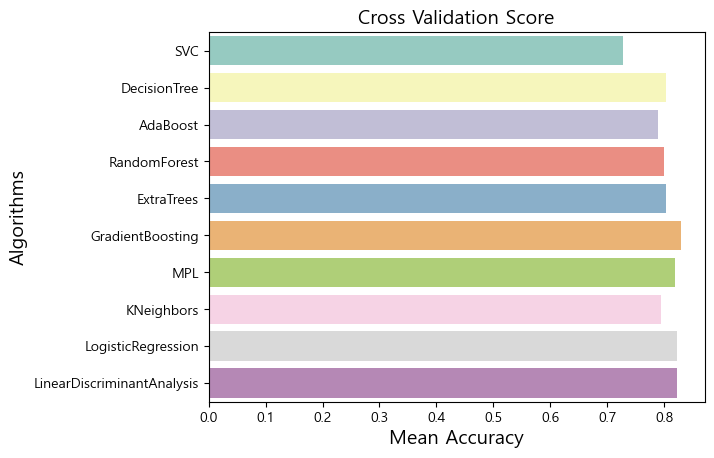

In [95]:
# modeling step
random_state=2

classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),
                   random_state=random_state, learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []

for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y=y_train, scoring="accuracy", 
                                      cv=kfold, n_jobs=-1))
    
cv_means = []
cv_std = []

for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_res = pd.DataFrame({"CrossValMeans":cv_means, "CrossValError":cv_std, "Algorithms":["SVC", 
                                                                                        "DecisionTree",
                                                                                        "AdaBoost",
                                                                                        "RandomForest",
                                                                                        "ExtraTrees",
                                                                                        "GradientBoosting",
                                                                                        "MPL",
                                                                                        "KNeighbors",
                                                                                        "LogisticRegression",
                                                                                        "LinearDiscriminantAnalysis"]})

g = sns.barplot(data=cv_res, x="CrossValMeans", y="Algorithms", orient="h",
                palette="Set3")
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross Validation Score")

He decided to choose the SVC, AdaBoost, RandomForest , ExtraTrees and the GradientBoosting classifiers for the ensemble modeling.

### Hyperparameters tunning for best model

In [100]:
### Meta modeling with Adaboost, RF, Extratrees, and GradientBossting

# AdaBoost
DTC = DecisionTreeClassifier()

adaDTC = AdaBoostClassifier(DTC, random_state=7)

ada_param_grid = {"estimator__criterion": ['gini', 'entropy'], # base_estimator '__' DT 에 접근
                  "estimator__splitter": ['best', 'random'],
                  "algorithm": ['SAMME', 'SAMME.R'],
                  "n_estimators": [1, 2],
                  "learning_rate": [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC, ada_param_grid, scoring="accuracy", 
                        cv=kfold, n_jobs=-1, verbose=1)

gsadaDTC.fit(X_train, y_train)

ada_best = gsadaDTC.best_estimator_
ada_best

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


C:\Users\admin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                   learning_rate=0.3, n_estimators=2, random_state=7)

In [101]:
gsadaDTC.best_score_

0.8275536261491316

In [108]:
# Extratree
ExtC = ExtraTreesClassifier()

ex_param_grid = {"max_depth": [None],
                 "max_features": [1, 3, 10],
                 "min_samples_split": [2, 3, 10],
                 "min_samples_leaf": [1, 3, 10],
                 "bootstrap": [False],
                 "n_estimators": [100, 300],
                 "criterion": ['gini']}

gsExtC = GridSearchCV(ExtC, ex_param_grid, scoring="accuracy", 
                      cv=kfold, n_jobs=-1, verbose=1)

gsExtC.fit(X_train, y_train)

ExtC_best = gsExtC.best_estimator_

gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8308605720122575

In [109]:
# RFC
RFC = RandomForestClassifier()

rf_param_grid = {"max_depth": [None],
                 "max_features": [1, 3, 10],
                 "min_samples_split": [2, 3, 10],
                 "min_samples_leaf": [1, 3, 10],
                 "bootstrap": [False],
                 "n_estimators": [100, 300],
                 "criterion": ['gini']}

gsRFC = GridSearchCV(RFC, rf_param_grid, scoring="accuracy",
                     cv=kfold, n_jobs=-1, verbose=1)

gsRFC.fit(X_train,y_train)

RFC_best = gsRFC.best_estimator_

gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8319841675178754

In [113]:
# GBC
GBC = GradientBoostingClassifier()

GBC_param_grid = {'loss': ['log_loss', 'exponential'], # deviance
                  'n_estimators': [100, 200, 300], # 100
                  'learning_rate': [0.1, 0.05, 0.01], # 0.1
                  'max_depth': [4, 8], # 3
                  'min_samples_leaf': [100, 150], # 1
                  'max_features': [0.3, 0.1]} # None

gsGBC = GridSearchCV(GBC, GBC_param_grid, scoring="accuracy",
                     cv=kfold, n_jobs=-1, verbose=1)

gsGBC.fit(X_train, y_train)

GBC_best = gsGBC.best_estimator_

gsGBC.best_score_

Fitting 10 folds for each of 144 candidates, totalling 1440 fits


0.8320097037793668

In [114]:
# SVC classifier
SVMC = SVC(probability=True)

svc_param_grid = {'kernel': ['rbf'],
                  'gamma': [.001, .01, .1, 1],
                  'C': [1, 10, 50, 100, 200, 300, 1000]}

gsSVMC = GridSearchCV(SVMC, svc_param_grid, scoring='accuracy',
                      cv=kfold, n_jobs=-1, verbose=1)

gsSVMC.fit(X_train, y_train)

SVMC_bset = gsSVMC.best_estimator_

gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.8331332992849847

### learning curve

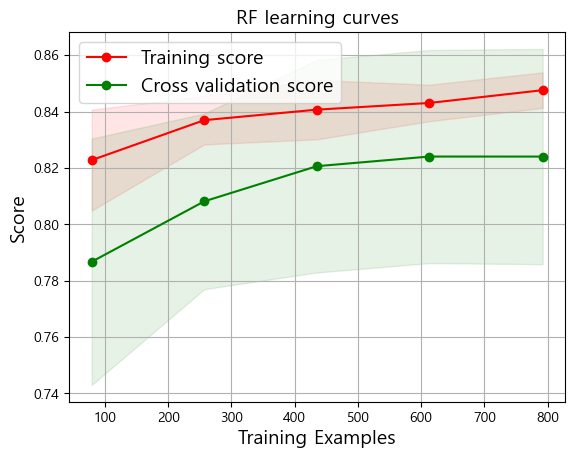

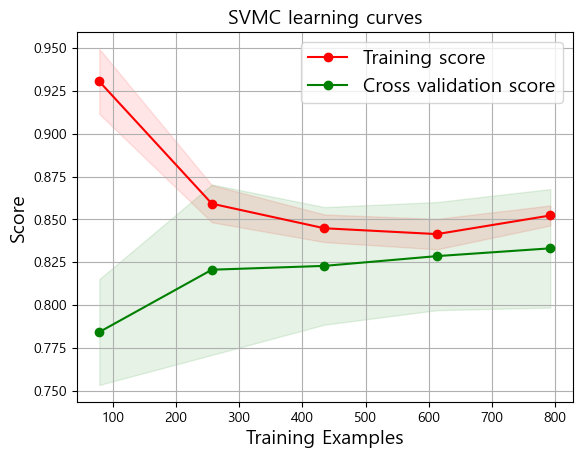

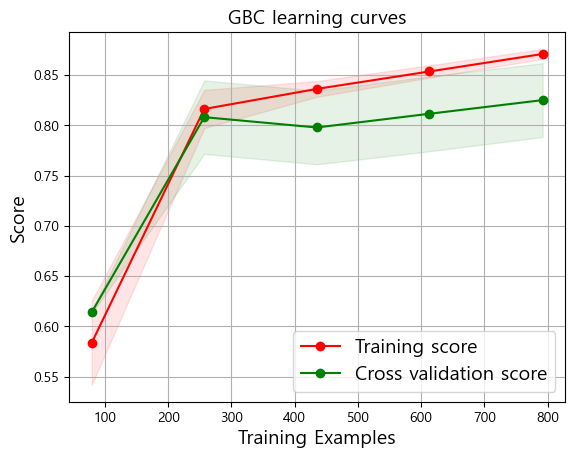

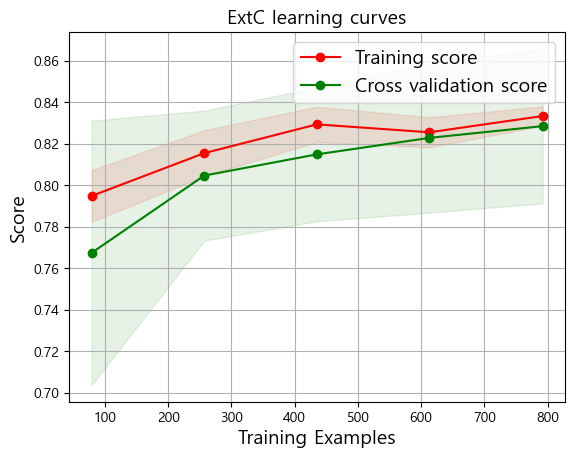

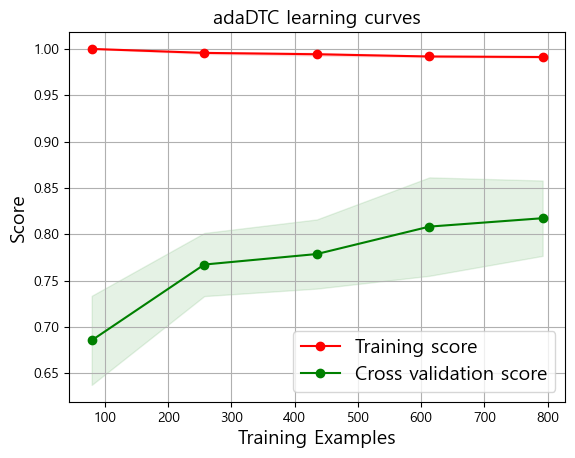

In [117]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1., 5)):
    # 그림 생성
    plt.figure()
    # 제목 생성
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
    
    # 축 이름 지정
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    
    
    # 러닝 커브 -> 사이즈, 스코어,
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    # 평균, 표준편차 계산
    train_scores_mean = np.mean(train_scores, axis=1) # 연산 -> axis=1
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    
    
    # 에러 표시
    plt.fill_between(train_sizes, train_scores_mean-train_scores_std, train_scores_mean+train_scores_std,
                     alpha=.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean-test_scores_std, test_scores_mean+test_scores_std,
                     alpha=.1, color='g')
    
    # 플롯 찍기
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label="Cross validation score")
    
    plt.legend(loc='best')
    
    return plt

# 모델 별 러닝 커브 생성
g = plot_learning_curve(gsRFC.best_estimator_, "RF learning curves", X_train, y_train, cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_, "SVMC learning curves", X_train, y_train, cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_, "GBC learning curves", X_train, y_train, cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_, "ExtC learning curves", X_train, y_train, cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_, "adaDTC learning curves", X_train, y_train, cv=kfold)

> <p style="font-style: italic; font-size=18px; line-height=1.8em"> 1. 에이다 부스트와 그래디언트 부스트는 과적합되는 경향을 보임. <br>
2. SVC와 ETC는 두 커브가 가까운 걸로 보아 예측을 잘 일봔화함
</p>

### Feature importance of tree based classifiers

feature importance for 4 tree models

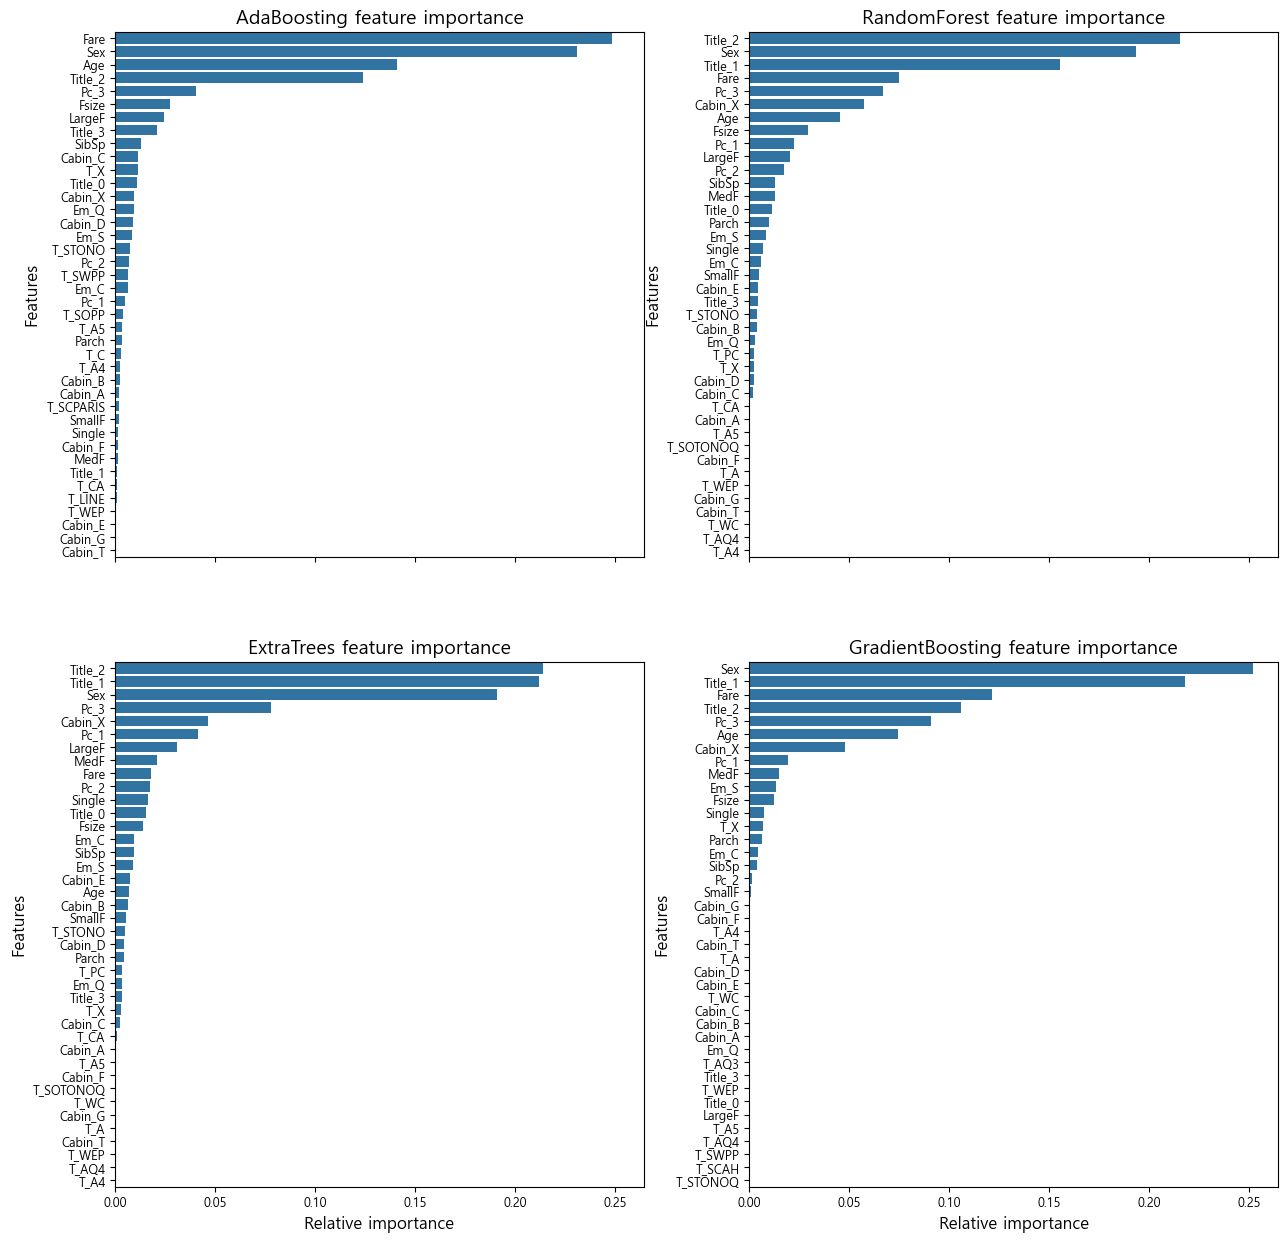

In [125]:
# 행 열 지정
n_rows = n_cols = 2

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, sharex='all', figsize=(15,15))

# 모델 리스트 지정
names_classifiers = [("AdaBoosting", ada_best),("ExtraTrees",ExtC_best),
                     ("RandomForest",RFC_best),("GradientBoosting",GBC_best)]

# 모델 선택 변수 
nclassifier = 0

# 행 열 반복하면서 플롯
for row in range(n_rows):
    for col in range(n_cols):
        '''
        figure의 1행 1열에는 adaboosting. 다 돌고 nclassifier +1 해서 1행 2열에는 ext
        '''
        # 이름은 튜플의 [0]으로 접근
        name = names_classifiers[nclassifier][0]
        # 모델은 튜플의 [1]로 접근
        classifier = names_classifiers[nclassifier][1]
        
        # 변수 중요도 정렬 -> 변수 어떤 변수를?
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        # 바플롯
        # horizontal barplot, y에는 변수 이름, x는 share하고 중요도
        g = sns.barplot(y=X_train.columns[indices][:40], x=classifier.feature_importances_[indices][:40],
                        orient='h', ax=axes[col][row])
        # figure 설정
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + " feature importance")
        
        nclassifier += 1

> <p style="line-height=2em"> 나이 feature : Title_1:어린아이 Age<br> 성별 feature : Title_2=여성, Title_3=남성, Sex<br>
    사회적 지위 feature : Pc_1,2,3, Fare<br> 승객의 가족 수 feature : LargeF, MedF, ...<br><br>
    *생존 예측에서 변수의 중요도는 탑승 위치 및 선승항보다 위 4가지 변수가 더 중요하다고 볼 수 있음
</p>

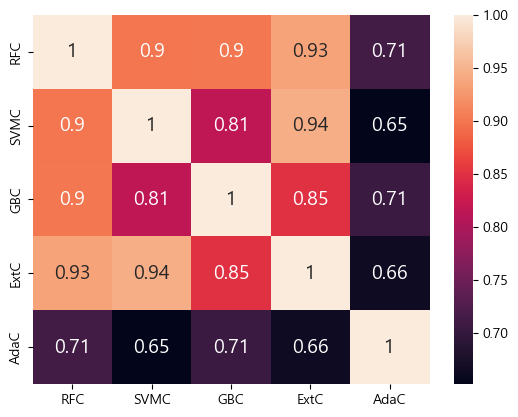

In [127]:
# Obtain corr matrix for diversty of ensemble model (for low variance, enhance performance ...)
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_SVMC = pd.Series(SVMC_bset.predict(test), name="SVMC")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="AdaC")

# concat: axis=1 --> 옆으로 붙히기
ensemble_results = pd.concat([test_Survived_RFC, test_Survived_SVMC, 
                              test_Survived_GBC, test_Survived_ExtC, test_Survived_AdaC], axis=1)

g = sns.heatmap(ensemble_results.corr(), annot=True)

## Ensemble modeling

### Combining models

In [129]:
votingC = VotingClassifier(estimators=[('rbf', RFC_best),
                                       ('svc', SVMC_bset),
                                       ('gbc', GBC_best),
                                       ('extc', ExtC_best),
                                       ('adac', ada_best)], voting='soft', n_jobs=-1)

votingC.fit(X_train, y_train)

VotingClassifier(estimators=[('rbf',
                              RandomForestClassifier(bootstrap=False,
                                                     max_features=10,
                                                     min_samples_leaf=10,
                                                     min_samples_split=3)),
                             ('svc', SVC(C=10, gamma=0.01, probability=True)),
                             ('gbc',
                              GradientBoostingClassifier(max_depth=8,
                                                         max_features=0.3,
                                                         min_samples_leaf=100,
                                                         n_estimators=300)),
                             ('extc',
                              ExtraTreesClassifier(max_features=10,
                                                   min_samples_leaf=10,
                                                   min_samples_split=3,
                                                   n_estimators=300)),
                             ('adac',
                              AdaBoostClassifier(estimator=DecisionTreeClassifier(criterion='entropy'),
                                                 learning_rate=0.3,
                                                 n_estimators=2,
                                                 random_state=7))],
                 n_jobs=-1, voting='soft')

> soft voting: 간접 투표로, 개별 분류기에서 확률을 추정하여 확률 평균 내어 예측